In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

In [3]:
import intake
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')
df = catalog.search(experiment='historical', component='ocn', stream='pop.h').df
variables = df.variable.unique()

In [8]:
[v for v in variables if 'do' in v.lower()]

['DOC',
 'DOC_RIV_FLUX',
 'DOC_prod',
 'DOC_prod_zint',
 'DOC_prod_zint_100m',
 'DOC_remin_zint',
 'DOC_remin_zint_100m',
 'DOCr',
 'DOCr_RIV_FLUX',
 'DOCr_remin_zint',
 'DOCr_remin_zint_100m',
 'DON',
 'DON_RIV_FLUX',
 'DON_prod',
 'DONr',
 'DONr_RIV_FLUX',
 'DOP',
 'DOP_RIV_FLUX',
 'DOP_diat_uptake',
 'DOP_diaz_uptake',
 'DOP_prod',
 'DOP_sp_uptake',
 'DOPr',
 'DOPr_RIV_FLUX',
 'Jint_100m_DOC',
 'Jint_100m_DOCr',
 'POC_REMIN_DOCr_zint',
 'POC_REMIN_DOCr_zint_100m',
 'diat_loss_doc_zint',
 'diat_loss_doc_zint_100m',
 'diaz_loss_doc_zint',
 'diaz_loss_doc_zint_100m',
 'graze_diat_doc_zint',
 'graze_diat_doc_zint_100m',
 'graze_diaz_doc_zint',
 'graze_diaz_doc_zint_100m',
 'graze_sp_doc_zint',
 'graze_sp_doc_zint_100m',
 'sp_loss_doc_zint',
 'sp_loss_doc_zint_100m',
 'tend_zint_100m_DOC',
 'tend_zint_100m_DOCr',
 'zoo_loss_doc_zint',
 'zoo_loss_doc_zint_100m']

In [5]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.54:41318 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area #.plot()

/glade/work/mclong/miniconda3/envs/co2-hole/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


<xarray.DataArray 'TAREA' (region: 1, nlat: 384, nlon: 320)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.52530781e+13, 1.52530781e+13, 1.52530781e+13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Dimensions without coordinates: region, nlat, nlon
Attributes:
    units:        cm^2
    long_name:    area of T cells
    coordinates:  TLONG TLAT

`dust_to_Fe`: conversion of dust to iron (nmol Fe/g Dust)
```
dust remin gDust = 0.035 gFe       mol Fe     1e3 mmolFe
                    --------- *  ----------- * ----------
                      gDust      molw_Fe gFe      molFe
```                      

In [ ]:
nmolcm3_to_µM = 1.

time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'DOC',
    'DOCr',
    'DON',
    'DONr',
    'DOP',
    'DOPr',
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    ))
    
ds = xr.merge(ds_list)
for v in ds.data_vars:
    if ds[v].attrs['units'] == 'mmol/m^3':
        ds[v].attrs['units'] = 'µM'
        
dsp = utils.pop_add_cyclic(ds)
dsp.info()        


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


In [52]:
df_glb = ds_glb.to_dataframe() #.sum(axis=1)
print(f'Global imbalance: {df_glb.sum(axis=1).values[0]:0.3f} Gmol/yr')
df_glb

Global imbalance: -0.032 Gmol/yr


,IRON_FLUX,Fe_from_dust,pfeToSed,Fe_ventflux,Fe_sedflux,Fe_RIV_FLUX
region,,,,,,
0,8.05681,5.566933,-38.614945,4.905846,19.681022,0.372556


In [53]:
client.close()
cluster.close()
del client
del cluster

In [6]:
df = discrete_obs.open_datastream('DOM')
df.obs_stream.add_model_field(ds.Fe)
df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
df

,month,lon,lat,depth,DOM_obs
0,3,310.698,-35.0880,11.9,3.054
1,3,310.698,-35.0880,28.3,5.135
2,3,310.698,-35.0880,41.7,4.190
3,3,310.698,-35.0880,45.1,4.787
4,3,310.698,-35.0880,49.6,3.513
...,...,...,...,...,...
72892,2,288.296,-32.5009,436.0,-1.000
72893,2,288.296,-32.5009,484.3,-1.000
72894,2,288.296,-32.5009,565.7,-1.000
72895,2,288.296,-32.5009,663.2,-1.000


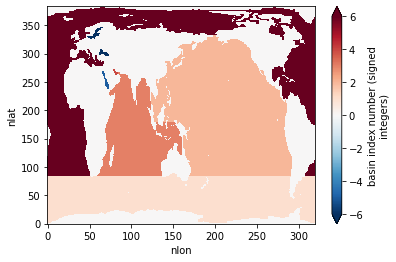

In [78]:
regions = {
    'Southern Ocean': 1,
    'Atlantic': 6, 
    'Indian': 3,
    'Pacific': 2,     
}
ds_grid.REGION_MASK.plot(vmax=6)

In [65]:
df = discrete_obs.open_datastream('dFe')
df.obs_stream.add_model_field(ds.Fe)
df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
df

,month,lon,lat,depth,dFe_obs,Fe,REGION_MASK
0,1,210.010,-16.0018,20.0,0.540000,0.065604,2.0
1,1,210.010,-16.0018,35.0,0.440000,0.065562,2.0
2,1,210.010,-16.0019,50.0,0.480000,0.066896,2.0
3,1,210.010,-16.0019,80.0,0.400000,0.081158,2.0
4,1,210.010,-16.0020,100.0,0.390000,0.096782,2.0
...,...,...,...,...,...,...,...
27777,732519,160.051,47.0032,3929.6,0.825681,0.850402,2.0
27778,732519,160.051,47.0032,3929.8,0.902248,0.850392,2.0
27779,732519,160.051,47.0032,4900.4,0.555630,NaN,2.0
27780,732519,160.051,47.0032,4900.9,0.621851,NaN,2.0


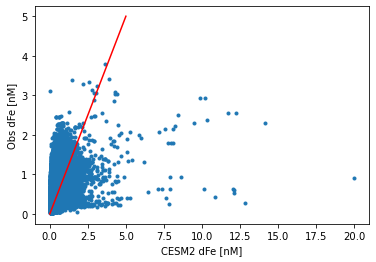

In [76]:
plt.plot(df.dFe_obs, df.Fe, '.')
plt.xlabel('CESM2 dFe [nM]')
plt.ylabel('Obs dFe [nM]')
plt.plot([0, 5], [0, 5], 'r-')

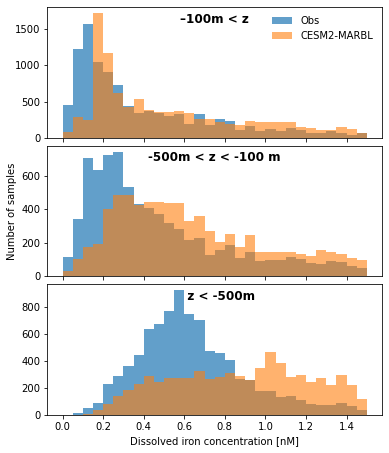

In [185]:
fig, axs = plot.canvas(3, 1, figsize=(6, 2.5), use_gridspec=True, hspace=0.06)

dx = 0.05
bin_edges = np.arange(0., 1.5+dx, dx)
bins = np.vstack((bin_edges[:-1], bin_edges[1:])).mean(axis=0)

depth_ranges = {
    '–100m < z': (0., 100.),
    '-500m < z < -100 m': (100., 500.),
    '   z < -500m': (500., 1e36),
}

for n, (key, depth_range) in enumerate(depth_ranges.items()):
    ax = axs[n, 0]
    df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
    
    hist, _ = np.histogram(df_sub.dFe_obs.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.7, label='Obs')
    
    hist, _ = np.histogram(df_sub.Fe.values, bin_edges)
    ax.bar(bins, hist, width=dx, alpha=0.6, label='CESM2-MARBL')
    
    if n == 0:
        ax.legend(loc='upper right', frameon=False)
    if n < 2:
        ax.set_xticklabels([])
    ylm = ax.get_ylim()
    ax.text(0.75, ylm[1] - 0.12 * np.diff(ylm), key, 
            fontweight='bold',
            fontsize=12,
            ha='center',
           )
    if n == 1:
        ax.set_ylabel('Number of samples')
    if n == 2:
        ax.set_xlabel('Dissolved iron concentration [nM]')
        
utils.savefig('iron-global-ocean-obs-PDF')

In [186]:
residence_time = -(global_Fe_inv / ds_glb.pfeToSed).values[0]
print(f'Fe residence time: {residence_time:0.2f} yr')

Fe residence time: 28.33 yr


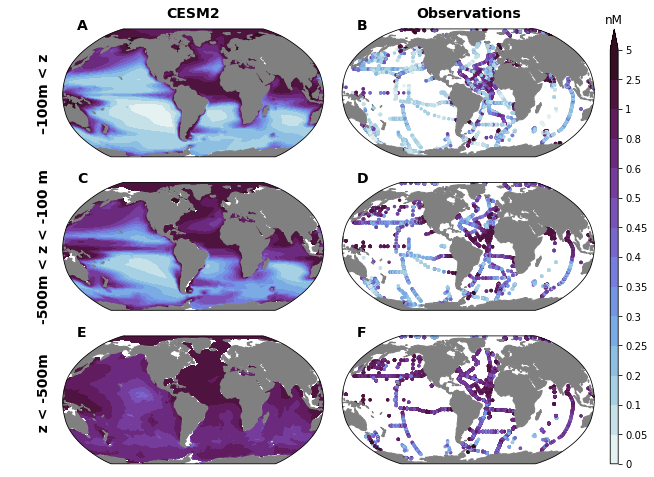

In [187]:
field = 'Fe'

levels = {'Fe': [0., 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1., 2.5, 5.0]}


fig = plt.figure(figsize=(10, 8))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 3, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.03),
    wspace=0.05, 
    hspace=0.2,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
cax = plt.subplot(gs[:, -1])

cmap_field = cmocean.cm.dense


for i, (key, depth_range) in enumerate(depth_ranges.items()):
    for j in range(2):
        ax = axs[i, j]
        if j == 0:
            zslice = slice(depth_range[0]*100., depth_range[1]*100.)

            cf = ax.contourf(
                dsp.TLONG,dsp.TLAT, dsp[field].sel(z_t=zslice).mean('z_t'),
                levels=levels[field],
                extend='max',
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                transform=ccrs.PlateCarree(),
            )
        else:
            df_sub = df.loc[(depth_range[0] <= df.depth) & (df.depth <= depth_range[1])]
            sc = ax.scatter(
                df_sub.lon, df_sub.lat, c=df_sub.dFe_obs.values,
                cmap=cmap_field,
                norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
                s=6,
                transform=ccrs.PlateCarree(),
            )

        land = ax.add_feature(
            cartopy.feature.NaturalEarthFeature(
                'physical','land','110m',
                edgecolor='face',
                facecolor='gray'
            )
        )  

cb = plt.colorbar(cf, cax=cax, ticks=levels['Fe'])
if 'units' in dsp[field].attrs:
    cb.ax.set_title(dsp[field].attrs['units'])
    cb.ax.set_yticklabels([f'{f:g}' for f in levels['Fe']])

utils.subplot_col_labels(axs[0, :], ['CESM2', 'Observations'])    
utils.subplot_row_labels(axs[:, 0], depth_ranges.keys(), xoff=60)
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('iron-concentration-maps.pdf')